In [1]:
import numpy as np
import pickle
import pathlib
import pyimfit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import angular_separation
import corner
import matplotlib.pyplot as plt
import pandas as pd
from photutils import profiles
from tqdm import tqdm
import logging
import warnings
warnings.filterwarnings('ignore')

imageFile = "../fit/agn.fits"
imageAGN = fits.getdata(imageFile)

medium_font_size = 14 
plt.rcParams['font.size'] = medium_font_size
plt.rcParams['axes.labelsize'] = medium_font_size
plt.rcParams['axes.titlesize'] = medium_font_size
plt.rcParams['xtick.labelsize'] = medium_font_size
plt.rcParams['ytick.labelsize'] = medium_font_size


# new script psf, no background subtraction
psf400 = fits.getdata("psf400.fits")
psf400new = fits.getdata("psf400_new.fits")
psf400_ovsp = fits.getdata('psf400_oversampled.fits')
psf100 = fits.getdata("psf100.fits")

In [2]:
# fit result with 100x100 frame
"""with open("../fit/fitResults/J1215+1344_fit.pkl", "rb") as file:
    d0 = pickle.load(file)  

modelName = ["1 psf+sersic same center", "2 psf+sersic same center","1 psf+sersic diff center", "2 psf+sersic diff center"]
dfs = [pd.DataFrame([d0['paramNames'][n],d0['bestfit_n1'][n]['params']],index=['',modelName[n]]).T for n in range(4)]
pd.concat(dfs, axis=1).fillna('')"""


'with open("../fit/fitResults/J1215+1344_fit.pkl", "rb") as file:\n    d0 = pickle.load(file)  \n\nmodelName = ["1 psf+sersic same center", "2 psf+sersic same center","1 psf+sersic diff center", "2 psf+sersic diff center"]\ndfs = [pd.DataFrame([d0[\'paramNames\'][n],d0[\'bestfit_n1\'][n][\'params\']],index=[\'\',modelName[n]]).T for n in range(4)]\npd.concat(dfs, axis=1).fillna(\'\')'

# True param radial profile and intensity

Radial profile integrated AGN up: 2447.443
Radial profile integrated AGN down: 2685.517
Intensity of whole image:25506.391


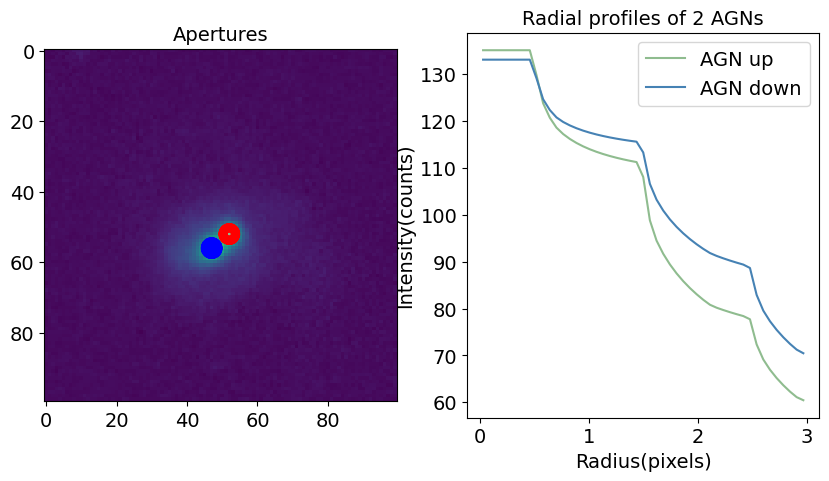

In [3]:
# plotting radial profiles
centeru = [52,52] #up
centerd = [47,56] #down
n = 1 # plot every n aperture
w = 3
r = np.linspace(0,w)

fig, ax = plt.subplots(1,2, figsize=(10,5))

agnup = profiles.RadialProfile(imageAGN,xycen=centeru,radii=r)
agndp = profiles.RadialProfile(imageAGN,xycen=centerd,radii=r)

im0 = ax[0].imshow(imageAGN)
[agnup.apertures[i].plot(ax=ax[0],color='r', lw=0.5) for i in range(len(agnup.apertures))]
[agndp.apertures[i].plot(ax=ax[0],color='b', lw=0.5) for i in range(len(agndp.apertures))]
#psf1.normalize("max")

agnup.apertures[int(3)].plot(ax=ax[0],color='darkseagreen', lw=0.5)

ax[1].plot(agnup.radius, agnup.profile, color='darkseagreen', label="AGN up")
ax[1].plot(agndp.radius, agndp.profile, color='steelblue', label="AGN down")
ax[1].legend()

[ax[i].set_title(["Apertures", "Radial profiles of 2 AGNs"][i]) for i in range(2)]
ax[1].set_xlabel("Radius(pixels)")
ax[1].set_ylabel("Intensity(counts)");

print(f"Radial profile integrated AGN up: {np.sum(agnup.profile*agnup.area):.3f}")
print(f"Radial profile integrated AGN down: {np.sum(agndp.profile*agndp.area):.3f}")
print(f"Intensity of whole image:{np.sum(imageAGN):.3f}")

# make galaxy models
I_tot is the integrated intensity. Feeding position at 50,70 gives model image at 49,69

In [133]:
def find_highest_indices(arr):
    """returns a tuple of ys, xs - indices of pixels with highest counts"""
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices

def makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                 sigma, sigma_lim, Isky, Isky_lim):
    """Return Sersic, PSF, and Gaussian model parameter dictionary"""
    # Sersic
    """sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}"""
    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 0, 10],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    # PSF
    psf = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]]}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}
    """psf = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]], 'PA':[PA_ss, PA_lim[0],PA_lim[1]] }
    psf_dict = {'name': "PointSourceRot", 'label': "psf", 'parameters': psf}"""
    # Gaussians
    gaussian = {'PA':[PA_ss, PA_lim[0],PA_lim[1]], 'ell':[ell_ss, ell_lim[0],ell_lim[1]], 
                'I_0':[I_ss, Iss_lim[0],Iss_lim[1]], 'sigma':[sigma, sigma_lim[0], sigma_lim[1]]}
    gaussian_dict = {'name': "Gaussian", 'label': "gaussian", 'parameters': gaussian}
    # Flat sky
    flatsky = {'I_sky': [Isky, Isky_lim[0], Isky_lim[1]]}
    flatsky_dict = {'name': "FlatSky", 'label': "flat_sky", 'parameters':flatsky}
    return sersic_dict, psf_dict, gaussian_dict, flatsky_dict
    
    
    
def galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, 
                    Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim, midf, Isky, Isky_lim):
    """Returns a function set dictionary with keys as model name, 
       values as model function set"""
    sersic_dict, psf_dict, gaussian_dict, flatsky_dict = makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                 sigma, sigma_lim, Isky, Isky_lim)
    #========function dictionary
    # psf
    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    # separate sersic
    funcset_dict_sersic0 = {'X0': [Xss0,Xsslim[0],Xsslim[1]], 'Y0': [Yss0,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xsslim[0],Xsslim[1]], 'Y0': [Yss1,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # overall sersic
    funcset_dict_sersicT = {'X0': [midf,Xsslim[0],Xsslim[1]], 'Y0': [midf,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # separate gaussian
    funcset_dict_gaussian0 = {'X0': [Xss0,Xsslim[0],Xsslim[1]], 'Y0': [Yss0,Ysslim[0],Ysslim[1]], 
                   'function_list': [gaussian_dict]}
    funcset_dict_gaussian1 = {'X0': [Xss1,Xsslim[0],Xsslim[1]], 'Y0': [Yss1,Ysslim[0],Ysslim[1]], 
                   'function_list': [gaussian_dict]}
    # same center psf+sersic
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    # same center psf+gaussian
    funcset_dict_psfgaus0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,gaussian_dict]}
    funcset_dict_psfgaus1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,gaussian_dict]}
    # overall gaussian
    funcset_dict_gaussianT = {'X0': [midf,Xsslim[0],Xsslim[1]], 'Y0': [midf,Ysslim[0],Ysslim[1]], 
                   'function_list': [gaussian_dict]}
    
    # with flatsky
    funcset_dict_psf_sky = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,flatsky_dict]}
    funcset_dict_sersic_sky = {'X0': [Xss0,Xsslim[0],Xsslim[1]], 'Y0': [Yss0,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict,flatsky_dict]}
    funcset_dict_psfser_sky = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,flatsky_dict,sersic_dict]}
    
    #========model dict
    funcset = {
        "2psf+sky": [funcset_dict_psf0,funcset_dict_psf_sky],
        "2psf+sersic,sameCenter+sky": [funcset_dict_psfser_sky,funcset_dict_psfser0],
        "1psf+sersic,1psf": [funcset_dict_psf1,funcset_dict_psfser0],
        "1psf+sky": [funcset_dict_psf_sky],
        
        "1psf": [funcset_dict_psf0],
        "1psf+sersic,sameCenter": [funcset_dict_psfser0],
        "1psf+gaussian,sameCenter": [funcset_dict_psfgaus0],
        
        "2psf": [funcset_dict_psf0, funcset_dict_psf1],
        "2psf+sersic,sameCenter": [funcset_dict_psfser0,funcset_dict_psfser1],
        "2psf+gaussian,sameCenter": [funcset_dict_psfgaus0,funcset_dict_psfgaus1],
        
        "1psf+sersic,diffCenter":[funcset_dict_psf0,funcset_dict_sersic0],
        "1psf+gaussian,diffCenter": [funcset_dict_psf0,funcset_dict_gaussian0],
        
        "2psf+sersic,diffCenter":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1],
        "2psf+gaussian,diffCenter":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_gaussian0,funcset_dict_gaussian1],
        
        "2psf,overall Sersic": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersicT],
        "2psf+sersic,sameCenter,overall Sersic": [funcset_dict_psfser0,funcset_dict_psfser1,funcset_dict_sersicT],
        "2psf+sersic,diffCenter,overall Sersic":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,
                                                 funcset_dict_sersic1,funcset_dict_sersicT],
        
        "2psf,overall Sersic": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersicT],
        "2psf+sersic,sameCenter,overall Sersic": [funcset_dict_psfser0,funcset_dict_psfser1,funcset_dict_sersicT],
        "2psf+sersic,diffCenter,overall Sersic":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,
                                                 funcset_dict_sersic1,funcset_dict_sersicT],
        
        "2psf,overall Gaussian": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_gaussianT],
        "2psf+gaussian,sameCenter,overall Gaussian": [funcset_dict_gaussianT,funcset_dict_psfgaus0,funcset_dict_psfgaus1],
        "2psf+gaussian,diffCenter,overall Gaussian":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_gaussian0,
                                                 funcset_dict_gaussian1,funcset_dict_gaussianT],
        
        "2psf+gaussian,sameCenter,overall Sersic": [funcset_dict_psfgaus0,funcset_dict_psfgaus1,funcset_dict_sersicT],
        "2psf+sersic,sameCenter,overall Gaussian": [funcset_dict_psfser0,funcset_dict_psfser1,funcset_dict_gaussianT]
    }
    return funcset


def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                sigma, sigma_lim,midf, Isky, Isky_lim):
    """return a dictionary of galaxy model with keys as model name"""
    funcset = galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim,midf, Isky, Isky_lim);
    models = {}
    for model in funcset:
        models[model]= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset[model]})
    return models


def dofit_no_oversp(modelName, dataImage, psf, readnoise=0.22, expT=1, skylevel = 654.63, solver="NM"):
    """do fit with not oversampled psf
       """
    fitter = pyimfit.Imfit(models_n1[modelName],psf=psf)
    fitter.loadData(dataImage, gain=9.942e-1,exp_time=expT, 
                    read_noise=readnoise, original_sky=skylevel,n_combined=4)
    fitter.doFit(solver)
    fitConfig = fitter.getModelDescription()
    fitModelImage = fitter.getModelImage()
    fitResult = fitter.getFitResult()
    param_names = fitter.numberedParameterNames
    return fitter, fitConfig, fitModelImage, fitResult, param_names


def crop_image(imageAGN, size=40):
    ysO,xsO = find_highest_indices(imageAGN)
    # find the center of AGNs
    ycO = int(np.sum(ysO)/2)
    xcO = int(np.sum(xsO)/2)
    # crop
    px=int(size/2)
    imageAGNcrop = imageAGN[ycO-px:ycO+px,xcO-px:xcO+px]
    # find agn centers in cropped image
    ys,xs = find_highest_indices(imageAGNcrop)
    return imageAGNcrop, ys, xs

    

def save_data(models,configs,modelIms,fitResults,pnames,filename):
    savedata = {}
    savedata['modelNames'] = models
    savedata['configs'] = configs
    savedata['modelImage'] = modelIms
    savedata['fitResults'] = fitResults
    savedata['paramNames'] = pnames
    pickle.dump(savedata,open(filename,"wb"))
    

def plot_fit(filename, figtitle):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    nrows=6
    ncols=3
    fig,ax = plt.subplots(nrows,ncols,figsize=(9,18))
    ax = ax.ravel()
    modelNum = len(d['fitResults'])
    fitStats = [d['fitResults'][i].fitStat for i in range(modelNum)]

    for i, j in zip(np.argsort(fitStats),np.arange(modelNum)):
        resi = imageAGNcrop-d['modelImage'][i]
        im = ax[j].imshow(resi,cmap="coolwarm")
        title = d['modelNames'][i]
        title = '\n'.join(title.split(',', 1)) if len(title) > 15 else title
        ax[j].set_title(title, fontsize=10)
        fig.colorbar(im, ax=ax[j], shrink=0.7)
        rmsNoise = np.sqrt(np.sum(resi**2)/imageAGNcrop.shape[0]**2)
        iRatio = np.sum(resi)/np.sum(imageAGNcrop)*100
        ax[j].text(0.05, 0.25, f"$\chi^2$:{fitStats[i]:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
        ax[j].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
        ax[j].text(0.05, 0.05, f"% I_res: {iRatio:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
    # turn off empty axes
    empty_axes = nrows*ncols-modelNum
    [ax[-i].axis('off') for i in np.arange(1,empty_axes+1)]
    fig.suptitle(figtitle)
    fig.tight_layout();
    
    
def plot_radial_fit(filename,dataImage,agnCenter):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    modelNum = len(d['fitResults'])
    fitStats = [d['fitResults'][i].fitStat for i in range(modelNum)]
    bestind = np.argsort(fitStats)
    fig,ax = plt.subplots()
    #plot models rp
    for i in range(modelNum):
        param_names=d['paramNames'][i]
        param_vals = d['fitResults'][i].params
        dic = dict(zip(param_names, param_vals))
        # if model has 1 psf
        if d['modelNames'][i][0] == "1":
            cen = [dic["X0_1"]-1, dic['Y0_1']-1]
        else:
            cenup = np.array([dic["X0_1"]-1, dic['Y0_1']-1])
            cendown = np.array([dic["X0_2"]-1, dic['Y0_2']-1])
            cen = (cenup+cendown)/2

        modelRP = profiles.RadialProfile(d['modelImage'][i],xycen=cen,radii=np.arange(50))
        if i==bestind[0]:
            ax.plot(modelRP.radius, modelRP.profile, color='royalblue', label="best 5 models", lw=2)
        else:
            ax.plot(modelRP.radius, modelRP.profile, color='steelblue', label="other models", alpha=0.2)
        #ax.plot(mRP.radius, agn.profile-mRP.profile, color='b', label="residual")
    # plot data rp
    agnRP = profiles.RadialProfile(dataImage,xycen=agnCenter,radii=np.arange(50))
    ax.plot(agnRP.radius, agnRP.profile, 'ko', label="data",markersize=1)    
    ax.set_title("Radial profiles data and models (free n)")
    ax.set_xlabel("Radius(pixels)")
    ax.set_ylabel("Intensity(counts)") 
    ax.set_ylim((0,150))

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5, label='data'),
        plt.Line2D([0], [0], color='royalblue', label='best model: '+d['modelNames'][bestind[0]]),
        plt.Line2D([0], [0], color='lightblue', label='other models')
    ]

    ax.legend(handles=legend_elements);
    
    
def fit_df(filename):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    modelNum = len(d['fitResults'])
    pd.set_option('display.max_colwidth',1)
    best5i = np.argsort([d['fitResults'][i].fitStat for i in range(modelNum)])[:5]
    dfs = [pd.DataFrame([d['paramNames'][n],d['fitResults'][n].params],index=['',d['modelNames'][n]]).T for n in best5i]
    dfs = pd.concat(dfs, axis=1).fillna('')
    newcol = [' \n '.join(col.split(',', 1)) if len(col) > 15 else col for col in dfs.columns]
    dfs.columns = newcol
    return dfs

In [134]:
# cropping image and find centers
imageAGNcrop, ys, xs = crop_image(imageAGN)
Imax = imageAGN.max()
itot=1500
framelim = imageAGNcrop.shape[0]
midF=framelim//2

# for testing 1 model at a time
def make1model(xpos,ypos,function_dict,psf,dataImage=imageAGNcrop):
    func_set_dict = {'X0': xpos, 'Y0': ypos, 
                    'function_list': [function_dict]}
    funcset = [func_set_dict]
    model= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset})
    fitter = pyimfit.Imfit(model,psf=psf)
    #fitter.loadData(dataImage, gain=9.942e-1,exp_time=1, 
                    #read_noise=0.22, original_sky=654.63,n_combined=4)
    return fitter


sersic_dict, psf_dict, gaussian_dict, flatsky_dict = makeModelDict(PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                                                                     PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                                                                     Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                                                                     sigma = 5, sigma_lim = [1,20], Isky = 2.5, Isky_lim =[0,10])


# make models
models_n1 = galaxy_model(X0=xs[0], Y0=ys[0], 
                         X1=xs[1], Y1=ys[1], 
                         Xss0=xs[0], Yss0=ys[0], 
                         Xss1=xs[1], Yss1=ys[1],
                         Xlim=[0,framelim], Ylim=[0,framelim], Xsslim = [0,framelim], Ysslim=[0,framelim],
                         PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                         PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                         Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                         sigma = 5, sigma_lim = [1,20],midf=midF, Isky = 2.5, Isky_lim =[0,10])

models_n1

{'2psf+sky': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3d8610>,
 '2psf+sersic,sameCenter+sky': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3d8e90>,
 '1psf+sersic,1psf': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3d9450>,
 '1psf+sky': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3d9910>,
 '1psf': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3d9ad0>,
 '1psf+sersic,sameCenter': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3d9f50>,
 '1psf+gaussian,sameCenter': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3da310>,
 '2psf': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3da790>,
 '2psf+sersic,sameCenter': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3dafd0>,
 '2psf+gaussian,sameCenter': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3dbd90>,
 '1psf+sersic,diffCenter': <pyimfit.descriptions.ModelDescription at 0x7f3f1b3db490>,
 '1psf+gaussian,diffCenter': <pyimfit.descriptions.ModelDescription at 0x7f3f1bb243d0>,
 '2psf+sersic,diffCenter': <

In [72]:
w = WCS(imageFile)
ra1,dec1 = w.pixel_to_world_values(dic['X0_2'],dic['Y0_2'])
ra2,dec2 = w.pixel_to_world_values(dic['X0_2']+dic['r_e_4'],dic['Y0_2']+dic['r_e_4'])
angular_separation(ra1,dec1,ra2,dec2)

0.0005031657325877397

sky level: 2.67


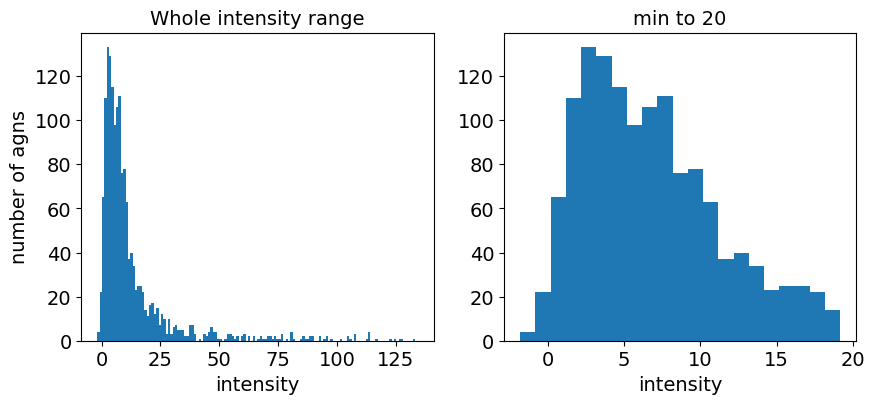

In [125]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),np.max(imageAGNcrop)))
bgr = ax[1].hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),20))
[ax[i].set_title(['Whole intensity range',"min to 20"][i]) for i in range(2)]
[ax[i].set_xlabel('intensity') for i in range(2)]
ax[0].set_ylabel('number of agns') 
sky = (bgr[1][np.where(bgr[0]==np.max(bgr[0]))]+bgr[1][np.where(bgr[0]==np.max(bgr[0]))[0][0]+1])/2
print(f"sky level: {sky[0]:.2f}")

Chi-squared: 41.02
X0_1: 23.278
Y0_1: 18.978
I_tot_1: 2599.163
X0_2: 18.401
Y0_2: 23.173
I_tot_2: 1673.981
PA_3: 250.777
ell_bulge_3: 0.440
n_3: 1.384
I_e_3: 18.347
r_e_3: 10.200


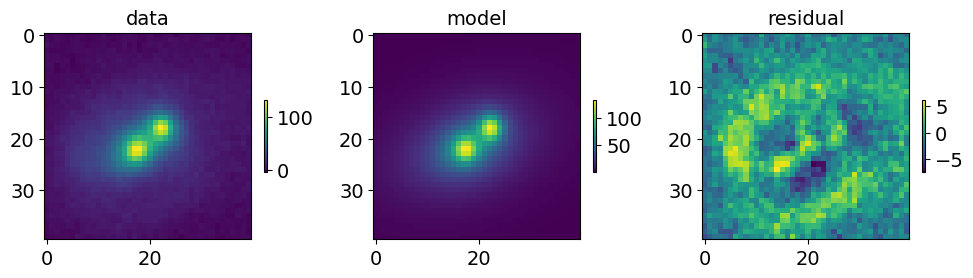

In [135]:
# Try for only 1 model
modelname = "1psf+sersic,1psf"
imageAGNcrop_bs = imageAGNcrop-sky
fitter0, config0, modelIm0, fitRes0, pname0  = dofit_no_oversp(modelname,
                                                      dataImage=imageAGNcrop_bs, psf=psf400new,solver="LM")
m = modelIm0
res = fitRes0.params
pname = pname0
fs = fitRes0.fitStat
print(f'Chi-squared: {fs:.2f}')
[print(f"{pname[i]}: {res[i]:.3f}") for i in range(len(pname))]
fig,ax = plt.subplots(1,3,figsize=(10,4))
im = [ax[i].imshow([imageAGNcrop-2.5, m, imageAGNcrop_bs-m][i]) for i in range(3)]
dic = dict(zip(pname, res))
[fig.colorbar(im[i],ax=ax[i],shrink=0.2) for i in range(3)]
[ax[i].set_title(['data','model','residual'][i]) for i in range(3)]
fig.tight_layout();

In [137]:
psf1 = res[:3]
#ss1 = res[6:]
psf2 = res[3:6]
ss2 = np.concatenate([res[3:5],res[6:]])
#sky = [20,20,res[-1]]
newparams = [psf1,psf2,ss2]
model_dicts = [psf_dict,psf_dict, sersic_dict]
n_comps = len(model_dicts)
model_images = []
for i in range(len(model_dicts)):
    fitter = make1model(20,20,model_dicts[i],psf=psf400new)
    mi = fitter.getModelImage(shape=[40,40],newParameters=newparams[i])
    model_images.append(mi) 


ModelObjectWrapper: about to call _model.CreateModelImage()...
ModelObjectWrapper: about to call _model.CreateModelImage()...
ModelObjectWrapper: about to call _model.CreateModelImage()...


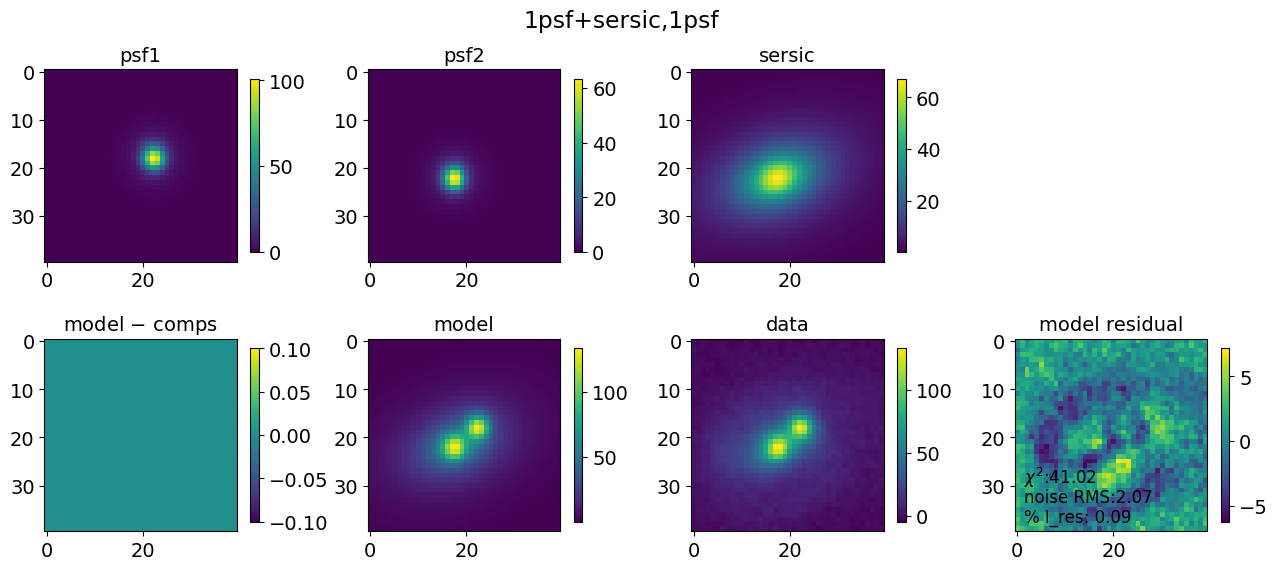

In [138]:
fig,ax = plt.subplots(2,4,figsize=(16,6))
for i in range(len(model_images)):
    im = ax[0,i].imshow(model_images[i])
    fig.colorbar(im, ax=ax[0,i], shrink=0.9)

model = np.sum(model_images, axis=0)
comp_resi = model-modelIm0
model_resi = model-imageAGNcrop+2.5
second_row=[comp_resi, model,imageAGNcrop-2.5,model_resi]    
for i in range(len(second_row)):
    im = ax[1,i].imshow(second_row[i])
    fig.colorbar(im, ax=ax[1,i], shrink=0.9)
        
rmsNoise = np.sqrt(np.sum(model_resi**2)/imageAGNcrop.shape[0]**2)
iRatio = np.abs(np.sum(model_resi)/np.sum(imageAGNcrop-2.5)*100)
ax[1,-1].text(0.05, 0.25, f"$\chi^2$:{fs:.2f}", transform=ax[1,-1].transAxes, fontsize=12, color='k')
ax[1,-1].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[1,-1].transAxes, fontsize=12, color='k')
ax[1,-1].text(0.05, 0.05, f"% I_res: {iRatio:.2f}", transform=ax[1,-1].transAxes, fontsize=12, color='k')
[ax[1,i].set_title(["model $-$ comps",'model','data','model residual'][i]) for i in range(len(second_row))]
[ax[0,-i].axis('off') for i in range(1,4-n_comps+1)]

[ax[0,i].set_title(['psf1','psf2','sersic'][i]) for i in range(n_comps)]
fig.suptitle(modelname)
fig.subplots_adjust(hspace=0.4,wspace=0.2)




In [4]:
def fit_multi(models):
    """fit all models in models
       return lists of model config, model images, fit results, and parameter names"""
    models = list(models.keys())
    configs = []
    modelIms = []
    fitResults = []
    pnames= []

    logging.basicConfig(filename='error.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
    # fit all models
    for modelName in tqdm(models, desc="Fitting models"):
        try:
            config, modelIm, fitRes, pname = dofit_no_oversp(modelName, dataImage=imageAGNcrop, psf=psf400new, solver="LM")
            configs.append(config)
            modelIms.append(modelIm)
            fitResults.append(fitRes)
            pnames.append(pname)
        except Exception as e:
            error_message = f"An error occurred for {modelName}: {e}"
            logging.error(error_message)
            print(error_message) 
            continue  
    return configs, modelIms, fitResults, pnames

# fit result analysis

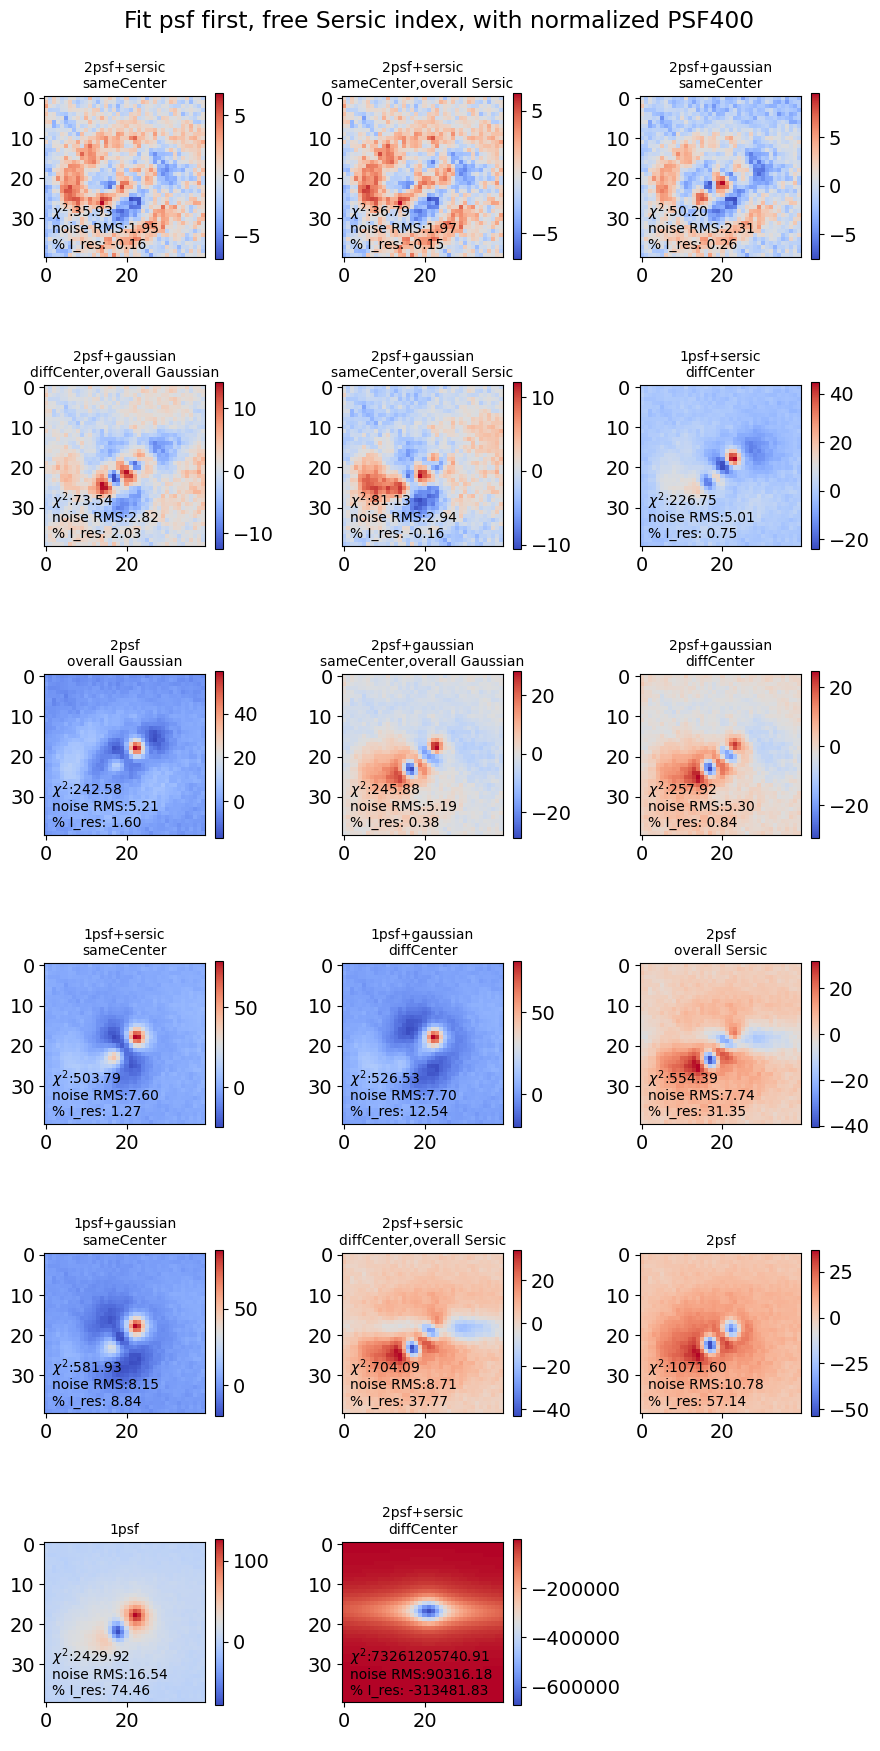

In [28]:
plot_fit("fit_20x20_psf400newFirst_freeN.pkl", "Fit psf first, free Sersic index, with normalized PSF400")

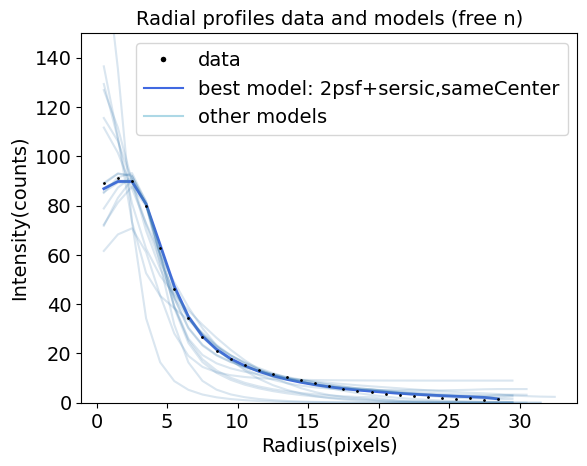

In [6]:
plot_radial_fit("fit_20x20_psf400First_freeN.pkl",imageAGNcrop,[np.average(xs),np.average(ys)])

In [9]:
fit_df("fit_20x20_psf400newFirst_freeN.pkl")

,,2psf+sersic \n sameCenter,,"2psf+sersic \n sameCenter,overall Sersic",,2psf+gaussian \n sameCenter,,"2psf+gaussian \n diffCenter,overall Gaussian",,"2psf+gaussian \n sameCenter,overall Sersic"
0,X0_1,18.351805,X0_1,18.394498,X0_1,18.354161,X0_1,18.367424,X0_1,18.221083
1,Y0_1,23.218465,Y0_1,23.202552,Y0_1,23.224227,Y0_1,23.365529,Y0_1,23.310677
2,I_tot_1,1379.07611,I_tot_1,1200.521124,I_tot_1,2311.569534,I_tot_1,2859.007613,I_tot_1,1777.586265
3,PA_2,251.555647,PA_2,251.082452,PA_2,250.153911,PA_2,360.0,PA_2,359.999991
4,ell_bulge_2,0.423623,ell_bulge_2,0.441109,ell_2,0.461801,ell_2,0.0,ell_bulge_2,0.0
5,n_2,2.797352,n_2,3.102134,I_0_2,58.068339,I_0_2,31.403828,n_2,2.327656
6,I_e_2,5.283831,I_e_2,4.784116,sigma_2,6.515402,sigma_2,7.828721,I_e_2,5.666098
7,r_e_2,22.998083,r_e_2,24.441217,X0_2,23.193377,X0_2,23.178967,r_e_2,16.585075
8,X0_2,23.271892,X0_2,23.349388,Y0_2,19.052878,Y0_2,19.306847,X0_2,23.337106
9,Y0_2,19.00755,Y0_2,18.845588,I_tot_3,2523.861456,I_tot_3,2635.277138,Y0_2,19.202322


In [17]:
def printFitResult(modelName):
    """format fit result to fidget with param values"""
    i = np.where(np.array(d['modelNames']) == modelName)[0][0]
    param_vals = d['fitResults'][i].params
    for i in param_vals:
        print(f"{i:.2f}, ", end="")
        
        
def plotNewP(modelName,newP,image,skylevel=654.63):
    """plot data, model, residual using new parameter set"""
    i = np.where(np.array(d['modelNames']) == modelName)[0][0]
    bf = d['fitResults'][i].params
    model = d['configs'][i]
    fitter = pyimfit.Imfit(model,psf=psf400)
    fitter.loadData(image, gain=9.942e-1, read_noise=0.22, original_sky=skylevel)
    modelImage = fitter.getModelImage(newParameters = newP)
    fig,ax = plt.subplots(1,3,figsize=(12,5))
    im0 = ax[0].imshow(image)
    #[ax[i].plot(newP[0]-1,newP[1]-1,"ro",markersize=0.5,markerfacecolor='none') for i in range(3)]
    #[ax[i].plot(newP[pos2_ind[0]]-1,newP[pos2_ind[1]]-1,"bo",markersize=0.5,markerfacecolor='none') for i in range(3)]
    im1 = ax[1].imshow(modelImage)
    im2 =ax[2].imshow(image-modelImage)
    [fig.colorbar([im0,im1,im2][i],ax=ax[i],shrink=0.7) for i in range(3)]
    [ax[i].set_title(["agn", "model", "residual"][i]) for i in range(3)];
    print("bf: ", fitter.computeFitStatistic(bf))
    print("new: ", fitter.computeFitStatistic(newP))
    
    
    
def plotRadial(m,modelName,dic,sep,imageAGN,data_center):
    """plot model residual,
        apertures,
        radial profile and residual"""
    # plot model image and apertures
    a = 10
    if sep:
        fig, ax = plt.subplots(1,4, figsize=(12,4))
    else:
        fig, ax = plt.subplots(1,3, figsize=(10,4))
    im0 = ax[0].imshow(imageAGN-m)
    ax[0].set_title("Residuals")
    im1 = ax[1].imshow(m)
    ax[1].set_title(f"Every {a} apertures")
    [fig.colorbar([im0,im1][i],ax=ax[i],shrink=0.7) for i in range(2)]
    cenup = np.array([dic["X0_1"]-1, dic['Y0_1']-1])
    cendown = np.array([dic["X0_2"]-1, dic['Y0_2']-1])
    cen = (cenup+cendown)/2
    if sep:
        # create AGN profiles separately
        agn0p = profiles.RadialProfile(imageAGN,xycen=centeru,radii=np.arange(50))
        agn1p = profiles.RadialProfile(imageAGN,xycen=centerd,radii=np.arange(50))
        # create model profiles
        m0 = profiles.RadialProfile(m,xycen=cenup,radii=np.arange(50))
        m1 = profiles.RadialProfile(m,xycen=cendown,radii=np.arange(50))
        [agn0p.apertures[int(a*i)].plot(ax=ax[1],color='darkseagreen', lw=0.5) for i in range(50//a)]
        [agn1p.apertures[int(a*i)].plot(ax=ax[1],color='steelblue', lw=0.5) for i in range(50//a)]
        # plot agn & model radial profiles
        ax[2].plot(agn0p.radius, agn0p.profile, 'ko', label="AGN up true",markersize=2)
        ax[3].plot(agn1p.radius, agn1p.profile, 'ro', label="AGN down true",markersize=2)
        ax[2].plot(m0.radius, m0.profile, color='y', label="AGN up model")
        ax[3].plot(m1.radius, m1.profile, color='steelblue', label="AGN down model")
        for i in [2,3]:
            ax[i].legend()
            ax[i].set_title("Radial profiles of 2 AGNs")
            ax[i].set_xlabel("Radius(pixels)")
            ax[i].set_ylabel("Intensity(counts)") 
    else:
        agn = profiles.RadialProfile(imageAGN,xycen=data_center,radii=np.arange(50))
        mRP = profiles.RadialProfile(m,xycen=cen,radii=np.arange(50))
        [agn.apertures[int(a*i)].plot(ax=ax[1],color='darkseagreen', lw=0.5) for i in range(50//a)]
        ax[2].plot(agn.radius, agn.profile, 'ko', label="data",markersize=2)
        ax[2].plot(mRP.radius, mRP.profile, color='y', label="model")
        ax[2].plot(mRP.radius, agn.profile-mRP.profile, color='b', label="residual")
        ax[2].legend()
        ax[2].set_title("Radial profiles of 2 AGNs")
        ax[2].set_xlabel("Radius(pixels)")
        ax[2].set_ylabel("Intensity(counts)") 
    fig.suptitle(modelName)
    fig.tight_layout();
    
def plotFit(m,dic,modelName,imageAGN):
    fig,ax = plt.subplots(1,3, figsize=(6,3))
    im = [ax[i].imshow([imageAGN, m, imageAGN-m][i]) for i in range(3)]
    cenup = np.array([dic["X0_1"]-1, dic['Y0_1']-1])
    cendown = np.array([dic["X0_2"]-1, dic['Y0_2']-1])
    [[ax[j].plot([cenup,cendown][i][0],[cenup,cendown][i][1],"ko") for i in range(2)] for j in range(2)]
    fig.colorbar(im[2],ax=ax[2],shrink=0.4);

def getResult(modelName, imageAGN,data_center, sep=False):
    i = np.where(np.array(d['modelNames']) == modelName)[0][0]
    param_names=d['paramNames'][i]
    param_vals = d['fitResults'][i].params
    model = d['modelImage'][i]
    ml =d['fitResults'][i].fitStat
    dic = dict(zip(param_names, param_vals))
    print("Model: "+str(modelName))
    print("\n")
    [print(f"{param_names[i]}: {param_vals[i]:.3f}") for i in range(len(param_names))]
    print("\n")
    print("ML:", ml)
    plotRadial(model,modelName,dic,sep,imageAGN,data_center)
    plotFit(model,dic,modelName,imageAGN)

Model: 2psf+sersic,sameCenter,overall Gaussian


X0_1: 18.359
Y0_1: 23.216
PA_1: 252.058
ell_bulge_1: 0.423
n_1: 1.000
I_e_1: 18.282
r_e_1: 10.534
I_tot_2: 2146.911
X0_2: 23.222
Y0_2: 19.050
PA_3: 357.122
ell_bulge_3: 0.284
n_3: 1.000
I_e_3: 0.923
r_e_3: 39.491
I_tot_4: 2391.372
X0_3: 14.228
Y0_3: 17.361
PA_5: 343.306
ell_5: 0.078
I_0_5: 3.783
sigma_5: 1.458


ML: 10.781563415005609


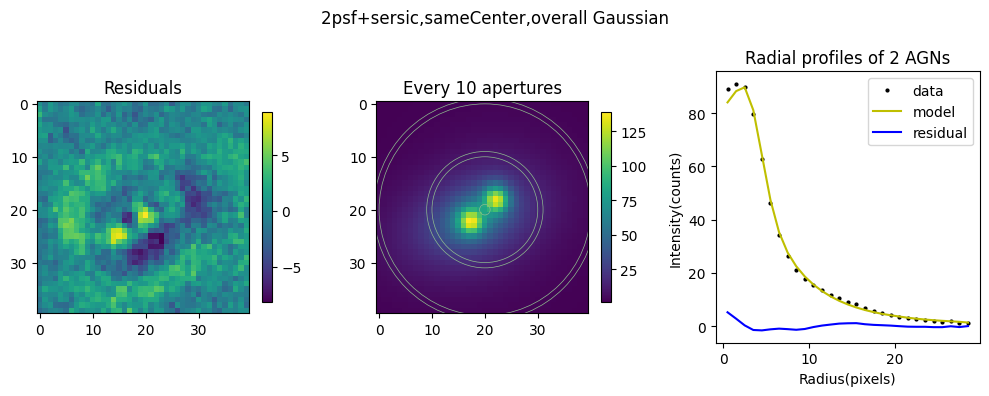

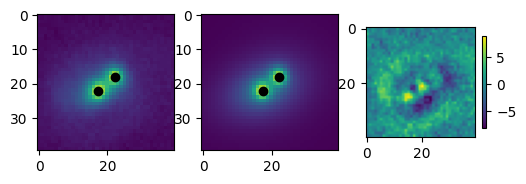

In [13]:
getResult("2psf+sersic,sameCenter,overall Gaussian", imageAGNcrop, data_center=[20,20])

In [70]:
printFitResult("2psf+sersic,sameCenter,overall Gaussian")
print('\n')
print(18.37, 23.20, 1485.20, 251.12, 0.42, 2.40, 6.94, 19.67, 23.27, 19.00, 2251.43, 166.25, 0.24, 1.26, 10.66, 1.65, 6.53, 12.58, 285.75, 0.10, 1.50, 5.14)

18.36, 23.22, 252.06, 0.42, 1.00, 18.28, 10.53, 2146.91, 23.22, 19.05, 357.12, 0.28, 1.00, 0.92, 39.49, 2391.37, 14.23, 17.36, 343.31, 0.08, 3.78, 1.46, 

18.37 23.2 1485.2 251.12 0.42 2.4 6.94 19.67 23.27 19.0 2251.43 166.25 0.24 1.26 10.66 1.65 6.53 12.58 285.75 0.1 1.5 5.14


bf:  10.781563415005609
new:  9.158176625177443


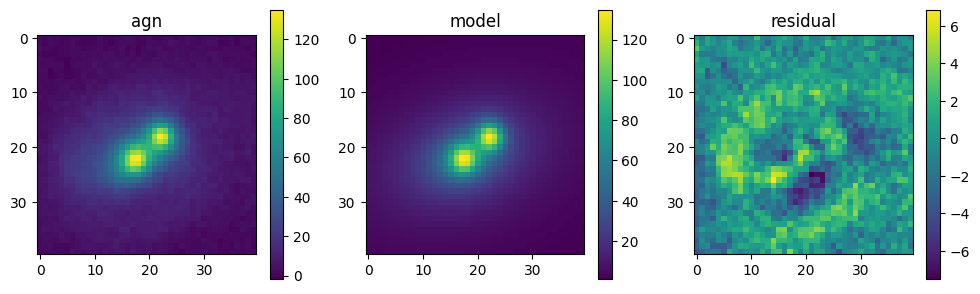

In [72]:
newp = [18.36, 23.22, 252.06, 0.42, 2.4, 6.94, 19.67, 1485.2, 
        23.22, 19.05, 166.25, 0.24, 1.26, 10.66, 1.65, 2251, 
        6, 12, 285, 0.1, 1.5, 5.14]
plotNewP("2psf+sersic,sameCenter,overall Gaussian",newp,image=imageAGNcrop)